In [1]:
from Integration_Methods import runge_kutta, eulers, implicit_runge_kutta
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, odeint

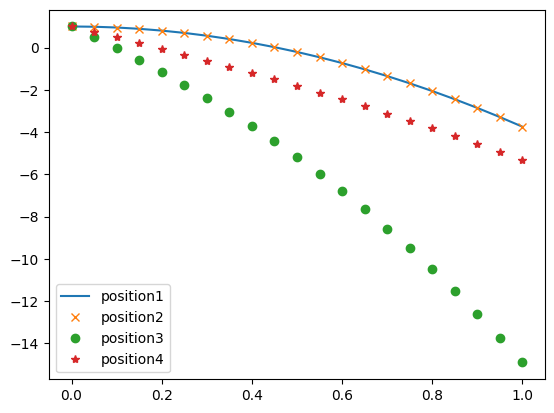

In [3]:
def diff(t, y):
    x, v = y
    return np.array([v, - 9.81 - .1*v])
t_eval = np.linspace(0, 1, 21)
y0 = np.array([1.0, 0.0])
y = solve_ivp(diff, [t_eval[0], t_eval[-1]], y0, t_eval=t_eval, method='Radau').y
y2 = odeint(diff, y0, t_eval, tfirst=True).T
t_values, y3 = implicit_runge_kutta(diff, t_eval, y0)
y3 = y3.T
y4, _, _, _ = runge_kutta(diff, y0, t_eval, args=())


plt.plot(t_eval, y[0], '-', label='position1')
# plt.plot(t_eval, y[1], label='velocity1')
plt.plot(t_eval, y2[0], 'x', label='position2')
# plt.plot(t_eval, y2[1], label='velocity2')
plt.plot(t_eval, y3[0], 'o', label='position3')
plt.plot(t_eval, y4[0], '*', label='position4')
plt.legend()

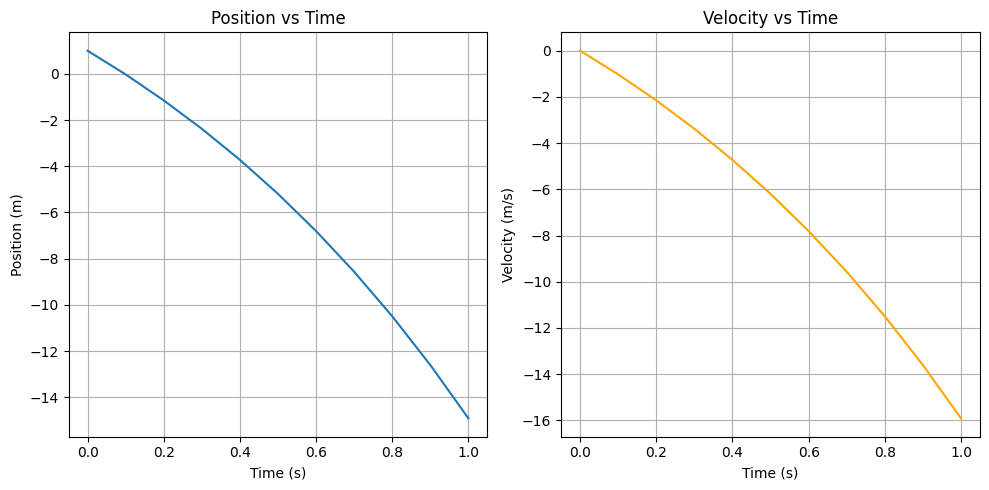

In [8]:
import numpy as np
from scipy.optimize import root
import matplotlib.pyplot as plt

# Define the system of equations (ball drop with air resistance)
def ball_system(t, z, g=9.81, k=0.1):
    y, v = z  # y is position, v is velocity
    dydt = v
    dvdt = -g - k * v  # Gravity and air resistance
    return np.array([dydt, dvdt])

# Define the implicit Runge-Kutta solver
def implicit_runge_kutta(f, t_span, z0, h, A, b, c):
    """
    Implicit Runge-Kutta solver for ODEs.

    Parameters:
        f: Function defining the ODE system, f(t, z).
        t_span: Tuple (t0, t_end) for the time interval.
        z0: Initial condition (array).
        h: Step size.
        A, b, c: Butcher tableau coefficients (IRK method).

    Returns:
        t_values, z_values: Arrays of time points and solutions.
    """
    t0, t_end = t_span
    t_values = [t0]
    z_values = [z0]
    s = len(b)  # Number of stages

    t = t0
    z = z0

    while t < t_end:
        # Adjust step size if the next step exceeds t_end
        if t + h > t_end:
            h = t_end - t

        # Solve for stages using nonlinear solver
        def residual(K):
            K = K.reshape(s, -1)
            residuals = []
            for i in range(s):
                stage = z + h * np.sum([A[i, j] * K[j] for j in range(s)])
                residuals.append(K[i] - f(t + c[i] * h, stage))
            return np.array(residuals).flatten()

        # Initial guess for K
        K0 = np.zeros((s, len(z))).flatten()

        # Solve for stages
        sol = root(residual, K0)
        if not sol.success:
            raise RuntimeError(f"Newton's method failed: {sol.message}")
        K = sol.x.reshape(s, -1)

        # Update solution
        z = z + h * np.sum([b[i] * K[i] for i in range(s)])
        t += h

        # Store results
        t_values.append(t)
        z_values.append(z)

    return np.array(t_values), np.array(z_values)

# Define the 2-stage Gauss-Legendre coefficients
A = np.array([
    [1/4, 1/4 - np.sqrt(3)/6],
    [1/4 + np.sqrt(3)/6, 1/4]
])
b = np.array([1/2, 1/2])
c = np.array([1/2 - np.sqrt(3)/6, 1/2 + np.sqrt(3)/6])

# Initial conditions and parameters
t_span = (0, 1)  # Simulate from t=0 to t=10 seconds
z0 = np.array([1, 0])  # Initial height = 100m, initial velocity = 0
h = 0.1  # Step size

# Solve the system
t_values, z_values = implicit_runge_kutta(ball_system, t_span, z0, h, A, b, c)

# Extract position and velocity
y_values = z_values[:, 0]  # Position
v_values = z_values[:, 1]  # Velocity

# Plot results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(t_values, y_values, label="Position (y)")
plt.title("Position vs Time")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(t_values, v_values, label="Velocity (v)", color="orange")
plt.title("Velocity vs Time")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.grid()

plt.tight_layout()
plt.show()


In [20]:
import numpy as np
from scipy.optimize import root
from numpy.polynomial.legendre import leggauss


def orthogonal_collocation_solver(f, y0, t_span, num_collocation_points):
    """
    Solves a first-order ODE using orthogonal collocation with Legendre-Gauss points.

    Parameters:
        f (function): ODE function of the form f(t, y).
        y0 (float): Initial condition.
        t_span (tuple): Tuple (t0, tf), start and end time.
        num_collocation_points (int): Number of collocation points.

    Returns:
        t_collocation (array): Collocation time points.
        y_collocation (array): Solution at collocation points.
    """
    t0, tf = t_span

    # Step 1: Get Legendre-Gauss collocation points and weights
    collocation_points, weights = leggauss(num_collocation_points)
    t_collocation = (collocation_points + 1) * (tf - t0) / 2 + t0  # Scale to [t0, tf]
    h = (tf - t0) / 2  # Scaling factor for time interval

    # Step 2: Compute differentiation matrix D
    def compute_differentiation_matrix(points):
        N = len(points)
        D = np.zeros((N, N))
        for i in range(N):
            for j in range(N):
                if i != j:
                    D[i, j] = np.prod([(points[i] - points[k]) / (points[j] - points[k])
                                      for k in range(N) if k != j])
                    D[i, j] /= (points[i] - points[j])
                else:
                    D[i, j] = -np.sum(D[i, :j]) - np.sum(D[i, j+1:])
        return D

    D = compute_differentiation_matrix(collocation_points)

    # Step 3: Define residual function
    def residual(variables):
        y = variables  # Flat array of solutions at collocation points
        dy_dt_approx = (1 / h) * np.dot(D, y)  # Approximate derivative
        f_values = np.array([f(t, y_val) for t, y_val in zip(t_collocation, y)])
        return dy_dt_approx - f_values

    # Step 4: Solve nonlinear system
    y_guess = np.full(num_collocation_points, y0)
    solution = root(residual, y_guess, method='hybr')

    if not solution.success:
        raise RuntimeError("Solver failed: " + solution.message)

    return t_collocation, solution.x


# Analytical solution
def analytical_solution(t):
    return (np.sin(t) - np.cos(t)) / 2 + 1.5 * np.exp(-t)


# Example ODE: dy/dt = -y + sin(t), y(0) = 1
def example_ode(t, y):
    return -y + np.sin(t)


if __name__ == "__main__":
    y0 = 1.0
    t_span = (0, 10)
    num_points = 10

    # Solve with orthogonal collocation
    t_collocation, y_numerical = orthogonal_collocation_solver(example_ode, y0, t_span, num_points)

    # Analytical solution
    y_analytical = analytical_solution(t_collocation)

    # Print results
    print("t\tNumerical\tAnalytical\tError")
    for i in range(len(t_collocation)):
        print(f"{t_collocation[i]:.2f}\t{y_numerical[i]:.5f}\t{y_analytical[i]:.5f}\t"
              f"{abs(y_numerical[i] - y_analytical[i]):.5e}")


t	Numerical	Analytical	Error
0.13	0.13010	0.88583	7.55728e-01
0.67	0.62465	0.68585	6.11992e-02
1.60	0.99948	0.81777	1.81714e-01
2.83	0.30370	0.71648	4.12788e-01
4.26	-0.89749	-0.20695	6.90541e-01
5.74	-0.51312	-0.68092	1.67799e-01
7.17	0.77315	0.07062	7.02529e-01
8.40	0.85613	0.68678	1.69344e-01
9.33	0.09930	0.54731	4.48014e-01
9.87	-0.43024	0.23632	6.66554e-01


In [70]:
import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt

# Define constants
k = 1.0         # Reaction rate constant
gamma = 0.5     # Decay rate of product B
C0 = 1.0        # Boundary condition: y1(0) = C0
PL = 0.5        # Boundary condition: y2(L) = PL
L = 5.0         # Length of the reactor (x in [0, L])

# Define the system of ODEs
def fun_2(x, y, dy, dy2):
    """
    System of ODEs:
    y[0] = y1 (Concentration of A)
    y[1] = y2 (Concentration of B)
    """
    dy1_dx = -k * y[0]
    dy2_dx = k * y[0] - gamma * y[1]
    return np.vstack((dy1_dx, dy2_dx))

# Boundary conditions
def bc_2(x, y, dy, dy2):
    """
    Boundary conditions:
    ya[0] = y1(0) = C0
    yb[1] = y2(L) = PL
    """
    return np.array([y[0] - C0, y[1] - PL])

In [71]:
#Number of collocatioin points
n_points = 6

#Create problem
problem_2 = OrthogonalCollocation(fun_2, bc_2, n_points, 1, x0=0.0, x1=L, vectorized=True)

#Initial estimation
y02 = np.zeros([2, n_points + 1])

#Collocation using scipy.optimize.root in backend
problem_2.collocate(y02, method="hybr", tol=1e-6)

In [72]:
# Define constants
k = 1.0         # Reaction rate constant
gamma = 0.5     # Decay rate of product B
C0 = 1.0        # Boundary condition: y1(0) = C0
PL = 0.5        # Boundary condition: y2(L) = PL
L = 5.0         # Length of the reactor (x in [0, L])


# Define the system of ODEs
def odes(x, y):
    """
    System of ODEs:
    y[0] = y1 (Concentration of A)
    y[1] = y2 (Concentration of B)
    """
    dy1_dx = -k * y[0]
    dy2_dx = k * y[0] - gamma * y[1]
    return np.vstack((dy1_dx, dy2_dx))

# Boundary conditions
def bc(ya, yb):
    """
    Boundary conditions:
    ya[1] = y1(L) = C0
    yb[1] = y2(L) = PL
    """
    return np.array([ya[1] - C0, yb[1] - PL])

# Initial mesh and guess for the solution
x = np.linspace(0, L, 50)  # Initial mesh with 50 points
y_guess = np.zeros((2, x.size))  # Initial guess for y1 and y2
y_guess[0, :] = C0 * (1 - x / L)  # Linear guess for y1
y_guess[1, :] = PL * x / L        # Linear guess for y2

# Solve the BVP
solution = solve_bvp(odes, bc, x, y_guess)

if not solution.success:
    raise RuntimeError("BVP solver failed to converge.")

# Plot the solution
x_plot = np.linspace(0, L, 100)
y_plot = solution.sol(x_plot)

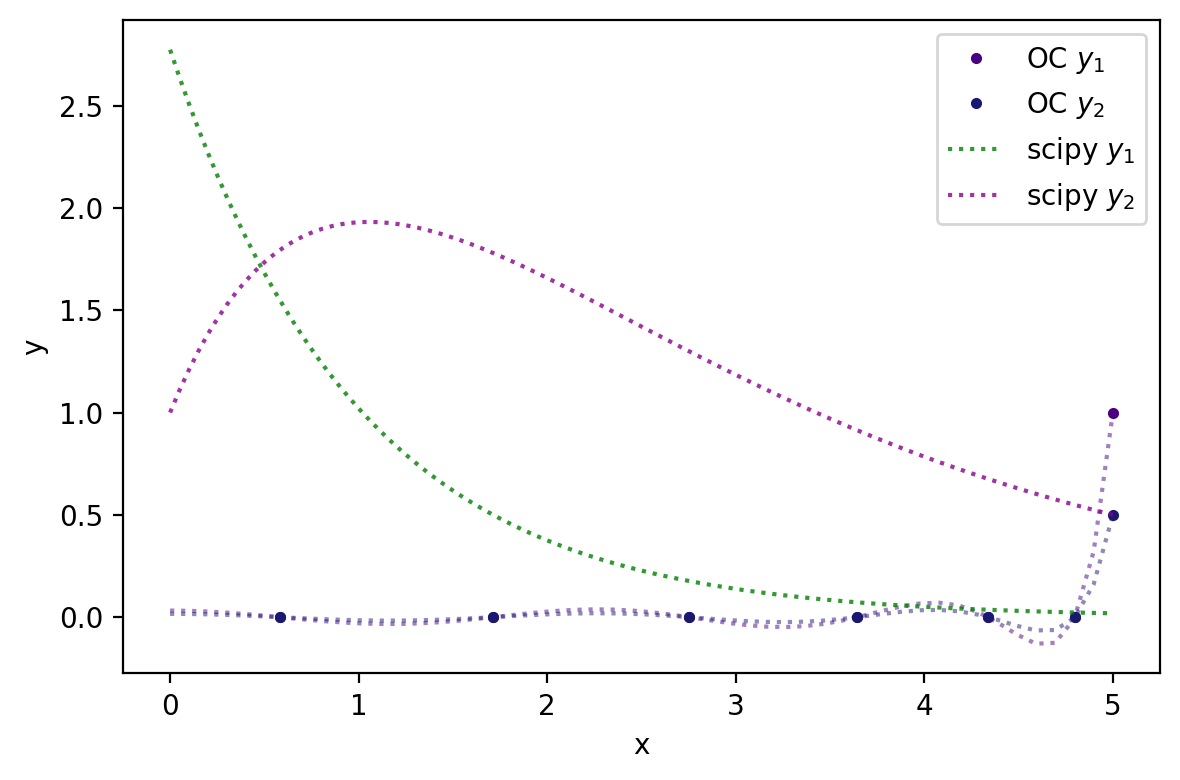

In [73]:
fig, ax = plt.subplots(figsize=[6, 4], dpi=200)

fig.patch.set_facecolor('white')

x = np.linspace(0, 5, 50)
ax.plot(x, problem_2.interpolate(x)[0], color="indigo", alpha=0.5, linestyle=":")
ax.plot(problem_2.x, problem_2.y[0], color="indigo", marker=".", label="OC $y_1$", linestyle=" ")
ax.plot(x, problem_2.interpolate(x)[1], color="midnightblue", alpha=0.5, linestyle=":")
ax.plot(problem_2.x, problem_2.y[1], color="midnightblue", marker=".", label="OC $y_2$", linestyle=" ")
ax.plot(x_plot, y_plot[0], color="green", alpha=0.8, linestyle=":", label="scipy $y_1$")
ax.plot(x_plot, y_plot[1], color="darkmagenta", alpha=0.8, linestyle=":", label="scipy $y_2$")

ax.set_ylabel("y")
ax.set_xlabel("x")

ax.legend()
fig.tight_layout()
plt.show()